In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models & Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, IsolationForest
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression

# Skewness & Transformation
from scipy.stats import skew, boxcox
from sklearn.impute import SimpleImputer

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load your dataset
df = pd.read_csv('C:\\Users\\Dell\\Downloads\\Copper_Set.xlsx - Result 1.csv', low_memory=False)  # Replace with your dataset path
df.head()


,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.1279489,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.4110654,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.5262616,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [19]:
!pip install xgboost


In [21]:
print(df.info())
print(df.describe())
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB
None
          item_date      customer        country    application  \
count  1.816720e+05  1.816720e+05 

In [23]:
# Convert 'Material_Reference' with '00000' as null
df['material_ref'] = df['material_ref'].apply(lambda x: np.nan if str(x).startswith("00000") else x)

# Drop 'INDEX' if present
if 'INDEX' in df.columns:
    df.drop('INDEX', axis=1, inplace=True)


In [24]:
# Separate numeric and categorical
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numeric with median, categorical with mode
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


In [25]:
# Using Isolation Forest
iso = IsolationForest(contamination=0.01)
outliers = iso.fit_predict(df[numeric_cols])
df = df[outliers == 1]


In [26]:
# Check and fix skewness
skewed_features = df[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.7].index

for feature in high_skew:
    df[feature] = np.log1p(df[feature])  # log1p is log(1 + x) which handles 0 values


In [27]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


MemoryError: Unable to allocate 30.1 GiB for an array with shape (179854, 179854) and data type bool

In [29]:
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()}")


id: 179854
quantity tons: 179856
status: 9
item type: 7
material_ref: 11438


In [30]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Drop the 'id' column
df.drop('id', axis=1, inplace=True)

# Categorical columns to encode
categorical_cols = ['status', 'item type', 'material_ref']

# Separate high and low cardinality columns
low_card_cols = [col for col in categorical_cols if df[col].nunique() < 50]
high_card_cols = [col for col in categorical_cols if df[col].nunique() >= 50]

# Label encode high cardinality columns
le = LabelEncoder()
for col in high_card_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode low cardinality columns
df_encoded = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# Done! You now have a memory-friendly encoded DataFrame


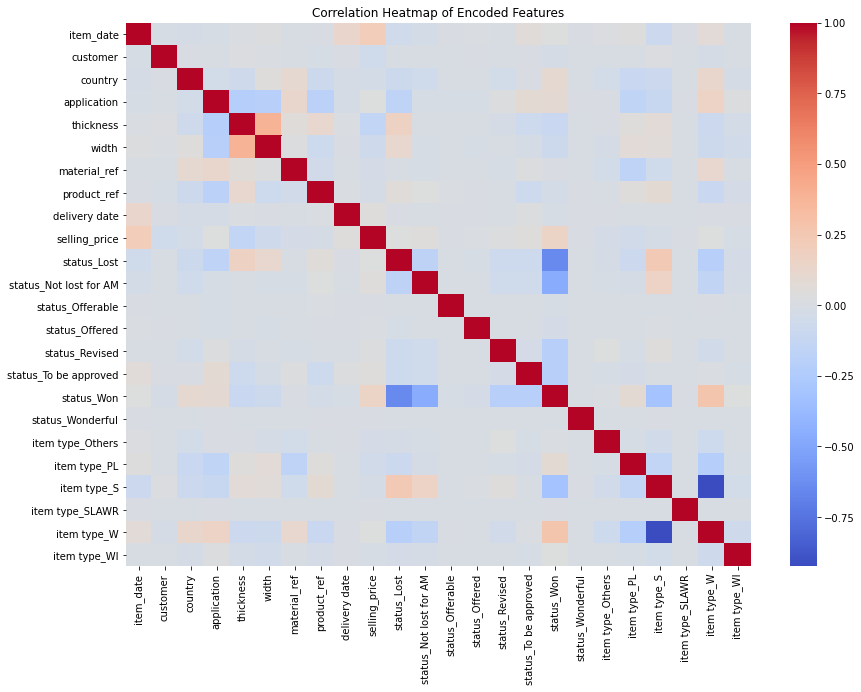

In [52]:
# Plot correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Encoded Features")
plt.show()


In [49]:
# Find non-numeric columns that shouldn't be there
non_numeric_cols = df_encoded.select_dtypes(include=['object']).columns
print("Non-numeric columns remaining:", non_numeric_cols)


Non-numeric columns remaining: Index([], dtype='object')


In [59]:
# Separate features and target for regression
X_reg = df_encoded.drop(columns=['selling_price'])  # Exclude both targets
y_reg = df_encoded['selling_price']


In [64]:
for col in ['selling_price', 'status']:
    if col in df_encoded.columns:
        print(f"✅ Column '{col}' exists.")
    else:
        print(f"❌ Column '{col}' NOT found. Use exact name: maybe it's 'Selling_Price'?")


✅ Column 'selling_price' exists.
❌ Column 'status' NOT found. Use exact name: maybe it's 'Selling_Price'?


In [60]:
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [61]:
import numpy as np

# Apply log1p transformation to handle skewness
y_train_log = np.log1p(y_train_reg)
y_test_log = np.log1p(y_test_reg)


In [62]:
from sklearn.preprocessing import StandardScaler

scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_scaled = scaler_reg.transform(X_test_reg)


In [65]:
# Check if there are any NaN values in the transformed target variable
print(y_train_log.isnull().sum())


5


In [66]:
# Drop rows with NaN values from both X_train_scaled and y_train_log
X_train_scaled_clean = X_train_scaled[~y_train_log.isnull()]
y_train_log_clean = y_train_log.dropna()

# Now, train the model on the cleaned data
regressor.fit(X_train_scaled_clean, y_train_log_clean)


ExtraTreesRegressor(random_state=42)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_scaled, y_train_log)

# Predict and reverse transform
y_pred_log = regressor.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)


In [ ]:
# Evaluate model
mse = mean_squared_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


In [ ]:
import pickle

# Save model
with open('regressor_model.pkl', 'wb') as f:
    pickle.dump(regressor, f)

# Save scaler
with open('regressor_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_reg, f)


In [76]:
# Re-initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features (same scaler used for regression)
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_test_class_scaled = scaler.transform(X_test_class)

# Initialize and train classifiers
from sklearn.ensemble import ExtraTreesClassifier
classifier_won = ExtraTreesClassifier(n_estimators=100, random_state=42)
classifier_lost = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Fit models for each target (status_won and status_lost)
classifier_won.fit(X_train_class_scaled, y_train_class['status_Won'])
classifier_lost.fit(X_train_class_scaled, y_train_class['status_Lost'])

# Make predictions
y_pred_class_won = classifier_won.predict(X_test_class_scaled)
y_pred_class_lost = classifier_lost.predict(X_test_class_scaled)

# Evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy_won = accuracy_score(y_test_class['status_Won'], y_pred_class_won)
accuracy_lost = accuracy_score(y_test_class['status_Lost'], y_pred_class_lost)

precision_won = precision_score(y_test_class['status_Won'], y_pred_class_won)
precision_lost = precision_score(y_test_class['status_Lost'], y_pred_class_lost)

recall_won = recall_score(y_test_class['status_Won'], y_pred_class_won)
recall_lost = recall_score(y_test_class['status_Lost'], y_pred_class_lost)

f1_won = f1_score(y_test_class['status_Won'], y_pred_class_won)
f1_lost = f1_score(y_test_class['status_Lost'], y_pred_class_lost)

roc_auc_won = roc_auc_score(y_test_class['status_Won'], classifier_won.predict_proba(X_test_class_scaled)[:, 1])
roc_auc_lost = roc_auc_score(y_test_class['status_Lost'], classifier_lost.predict_proba(X_test_class_scaled)[:, 1])

# Display metrics for both classifiers
print(f"Accuracy (status_Won): {accuracy_won:.4f}")
print(f"Accuracy (status_Lost): {accuracy_lost:.4f}")
print(f"Precision (status_Won): {precision_won:.4f}")
print(f"Precision (status_Lost): {precision_lost:.4f}")
print(f"Recall (status_Won): {recall_won:.4f}")
print(f"Recall (status_Lost): {recall_lost:.4f}")
print(f"F1 Score (status_Won): {f1_won:.4f}")
print(f"F1 Score (status_Lost): {f1_lost:.4f}")
print(f"AUC Score (status_Won): {roc_auc_won:.4f}")
print(f"AUC Score (status_Lost): {roc_auc_lost:.4f}")


Accuracy (status_Won): 0.9679
Accuracy (status_Lost): 0.9704
Precision (status_Won): 0.9749
Precision (status_Lost): 0.9282
Recall (status_Won): 0.9752
Recall (status_Lost): 0.9144
F1 Score (status_Won): 0.9750
F1 Score (status_Lost): 0.9213
AUC Score (status_Won): 0.9903
AUC Score (status_Lost): 0.9892


In [78]:
import joblib

# Save models and scaler
joblib.dump(regressor, "regressor_model.pkl")
joblib.dump(classifier_won, "classifier_won_model.pkl")
joblib.dump(classifier_lost, "classifier_lost_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']